In [14]:
# LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel

from math import sqrt

from sklearn.cluster import KMeans
sns.set_theme(style="darkgrid")


In [15]:
# CONSTANTS 
WEIGHT_THRESHOLD = 5

In [16]:
pd.options.display.width = 0
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',500)

In [17]:
# def squared_norm(x):
#     """Squared Euclidean or Frobenius norm of x.

#     Faster than norm(x) ** 2.

#     Parameters
#     ----------
#     x : array-like
#         The input array which could be either be a vector or a 2 dimensional array.

#     Returns
#     -------
#     float
#         The Euclidean norm when x is a vector, the Frobenius norm when x
#         is a matrix (2-d array).
#     """
#     x = np.ravel(x, order="K")
#     if np.issubdtype(x.dtype, np.integer):
#         warnings.warn(
#             (
#                 "Array type is integer, np.dot may overflow. "
#                 "Data should be float type to avoid this issue"
#             ),
#             UserWarning,
#         )
#     return np.dot(x, x)


def norm(x):
    """Dot product-based Euclidean norm implementation.

    See: http://fa.bianp.net/blog/2011/computing-the-vector-norm/

    Parameters
    ----------
    x : array-like
        Vector for which to compute the norm.
    """
    return sqrt(squared_norm(x))
    
def NNDSVD_init(X, n_components, init=None, eps=1e-6, random_state=None):

    check_non_negative(X, "NMF initialization")
    n_samples, n_features = X.shape

    U, S, V = randomized_svd(X, n_components, random_state=random_state)
    W = np.zeros_like(U)
    H = np.zeros_like(V)

    # The leading singular triplet is non-negative
    # so it can be used as is for initialization.
    W[:, 0] = np.sqrt(S[0]) * np.abs(U[:, 0])
    H[0, :] = np.sqrt(S[0]) * np.abs(V[0, :])

    for j in range(1, n_components):
        x, y = U[:, j], V[j, :]

        # extract positive and negative parts of column vectors
        x_p, y_p = np.maximum(x, 0), np.maximum(y, 0)
        x_n, y_n = np.abs(np.minimum(x, 0)), np.abs(np.minimum(y, 0))

        # and their norms
        x_p_nrm, y_p_nrm = norm(x_p), norm(y_p)
        x_n_nrm, y_n_nrm = norm(x_n), norm(y_n)

        m_p, m_n = x_p_nrm * y_p_nrm, x_n_nrm * y_n_nrm

        # choose update
        if m_p > m_n:
            u = x_p / x_p_nrm
            v = y_p / y_p_nrm
            sigma = m_p
        else:
            u = x_n / x_n_nrm
            v = y_n / y_n_nrm
            sigma = m_n

        lbd = np.sqrt(S[j] * sigma)
        W[:, j] = lbd * u
        H[j, :] = lbd * v

    W[W < eps] = 0
    H[H < eps] = 0

    return W, H

In [18]:
def show_kmeans_clusters(data, x, y, hue, kmeans, title):
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(8, 8))
    
    scat = sns.scatterplot(
        data=data,
        x=x,
        y=y,
        hue=hue,
        palette="Set2",
    )
    
    scat.set_title(title)
    
    # Obtener los centroides
    centroids = kmeans.cluster_centers_
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # Graficar los centroides
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
    
    plt.show()

In [19]:
def build_community_information_matrix(cluster_assignments):
    
    # Crear la matriz de membresía
    num_nodes = len(cluster_assignments)

    membership_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(num_nodes):
            # Verificar si los elementos pertenecen al mismo cluster
            if cluster_assignments[i] == cluster_assignments[j]:
                membership_matrix[i, j] = 1
    return membership_matrix

In [20]:
def draw_elbow_method_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # elbow method to select k value (number of clusters)
    # A list holds the SSE values for each k
    
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        sse.append(kmeans.inertia_)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.show()
    
def draw_silhouette_score_to_get_optimum_n_clusters(features, kmeans_kwargs):
    # silhouette coefficients method to select k value (number of clusters)
    # A list holds the silhouette coefficients for each k
    silhouette_coefficients = []
    
    # Notice you start at 2 clusters for silhouette coefficient
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(features)
        score = silhouette_score(features, kmeans.labels_)
        silhouette_coefficients.append(score)
    
    plt.style.use("fivethirtyeight")
    plt.plot(range(2, 11), silhouette_coefficients)
    plt.xticks(range(2, 11))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Coefficient")
    plt.show()


In [21]:
# Applying k-means algorithm 
def apply_kmeans(features, n_clusters, kmeans_kwargs, x, y, feature_names):

    k = n_clusters
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    kmeans_df =  pd.DataFrame(
        features,
        columns=feature_names
    )

    kmeans_df["predicted_cluster"] = kmeans.labels_

    show_kmeans_clusters(data=kmeans_df, kmeans=kmeans, x=x,
        y=y, hue="predicted_cluster",
            title="Clustering results")

    return build_community_information_matrix(cluster_assignments=kmeans_df["predicted_cluster"])

In [22]:
def apply_rbf_to_get_similarity(features, gamma=1):
    rbf_matrix = rbf_kernel(features, gamma=gamma)  # Ajusta gamma según tu necesidad
    return rbf_matrix

In [23]:
def compareNodes(f_list, s_list):
    """
        Function that returns the number of users that have interact with both items
        Funcion que devuelve el numero de usuarios que han interactuado con ambos items
    """
    peso = len(np.intersect1d(f_list, s_list))
    
    return peso
    
def createLinks(prob_us_set, nodos, threshold):
    """
        Function that creates graph links with the information about the set. The weight has to be grater or equal to threshold.
        
        Funcion que crea los enlaces del grafo a partir de la informacion contenida en el conjunto que se le
        pasa a la funcion. El peso tiene que ser mayor o igual al umbral.
        
        Format of links list -> [(Node1, Node2, weight), ......]
    """
    resultado = list()  
    
    # hago todas las posibles combinaciones de problemas
    for fst, snd in it.combinations(nodos, 2):
        # obtengo el peso pasando la lista de usuarios que ha hecho cada problema
        peso = compareNodes(prob_us_set[fst], prob_us_set[snd])
        if peso >= threshold:
            resultado.append((fst, snd, peso))
            
    return resultado

In [24]:
def create_graph_nx(list_nodes, list_links):
    """
        Function that creates a graph with the format from NetworkX 
        
        Funcion que crea un grafo de tipo Graph de la libreria NetworkX
        Construccion del grafo: http://networkx.readthedocs.io/en/networkx-1.11/tutorial/tutorial.html#what-to-use-as-nodes-and-edges
    """
    grafo = nx.Graph() # creo la variable grafo

    # incluyo los nodos del grafo 
    grafo.add_nodes_from(list_nodes)

    # se incluyen las tuplas de enlaces con el peso del enlace
    # es una lista de la forma [(Nodo1, Nodo2, peso), ......]
    grafo.add_weighted_edges_from(list_links)

    return grafo

def build_adjacency_matrix(graph):
    return nx.to_pandas_adjacency(graph)

In [25]:
def main_process(df):

    #K-means
    column_names_kmeans = ["Actual_price_log", "Category_name_encoded_log"]
    features = df[column_names_kmeans]

    scaler = RobustScaler()
    scaled_features = scaler.fit_transform(features)
    
    kmeans_kwargs = {
        "init": "k-means++",
        "n_init": 10,
        "max_iter": 300,
    }

    # Applying k-means clustering
    draw_elbow_method_to_get_optimum_n_clusters(scaled_features, kmeans_kwargs)
    draw_silhouette_score_to_get_optimum_n_clusters(scaled_features, kmeans_kwargs)
    n_clusters = 2 # This must be selected according to elbow_method and silhouette_score
    community_matrix = apply_kmeans(scaled_features, n_clusters, kmeans_kwargs,
            x=column_names_kmeans[0], y=column_names_kmeans[1], feature_names=column_names_kmeans)

    # Applying RBF to get attribute similarity between vectors
    similarity_matrix = apply_rbf_to_get_similarity(features=scaled_features)

    # # BUILDING ADJACENCY MATRIX
    
    # #Conjunto con todas las interacciones de los usuarios, fueron extraidas las interacciones del usuario
    # # objetivo con los items bajo evaluación. Esto debe ser extraido de la base de datos
    # training_set = pd.read_csv('user-datasets/user_' + str(user) + '_training.csv') 

    # # Conjunto de interacciones del usuario objetivo con los productos seleccionados para evaluar.
    # # Esto debe ser extraido de la base de datos
    # evaluation_set = pd.read_csv('user-datasets/user_' + str(user) + '_test.csv')

    # # I get the list of nodes
    # nodes = training_set.item.unique()
 
    # # I create a dictionary: keys are the items, and values are the list of users that are interacted with this item
    # grouped = training_set.groupby('item')['user'].apply(list)

    # # I create the links with the suitable format for nx
    # links = createLinks(grouped, nodes, WEIGHT_THRESHOLD)
 
    # ##################### GRAPH CREATION
    # # I create the graph
    # graph = create_graph_nx(nodes, links)

    # # Build adjacency matrix
    # adjacency_matrix_pd = build_adjacency_matrix(graph)    

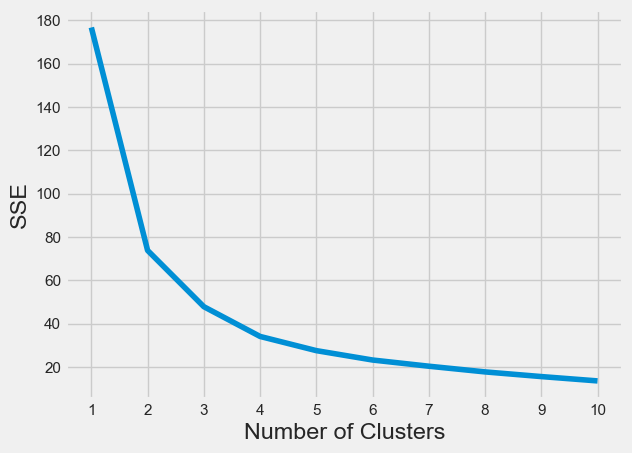

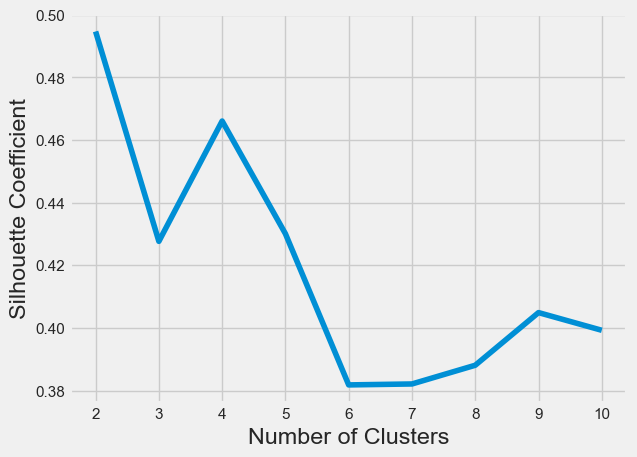

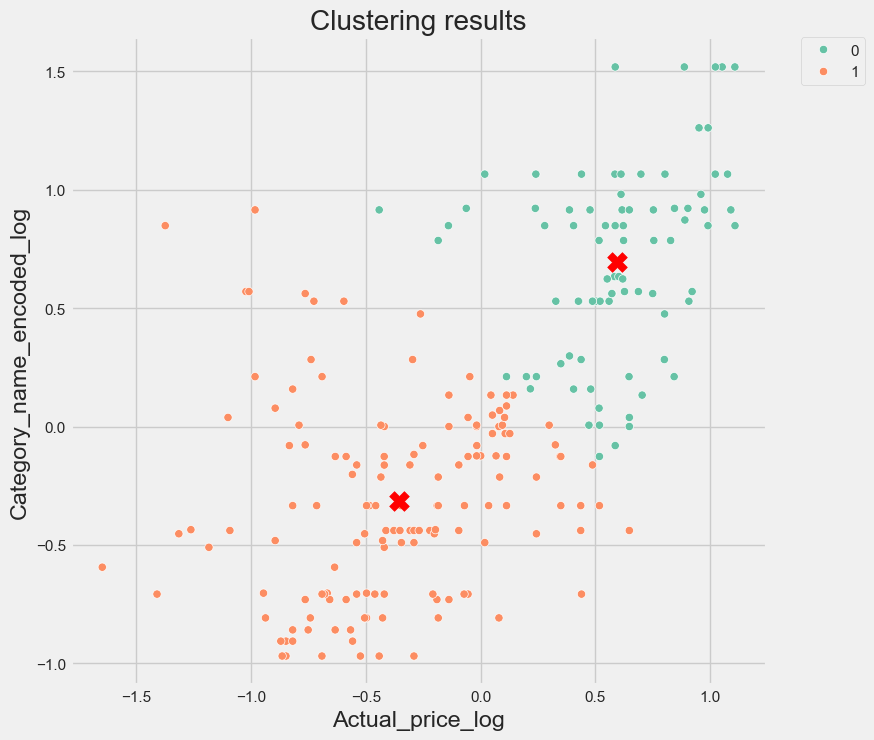

[[1.         0.42178492 0.72078443 ... 0.0437147  0.04196097 0.06282257]
 [0.42178492 1.         0.83685869 ... 0.43471894 0.42851456 0.4851203 ]
 [0.72078443 0.83685869 1.         ... 0.23840827 0.23177614 0.30350871]
 ...
 [0.0437147  0.43471894 0.23840827 ... 1.         0.99972896 0.97573336]
 [0.04196097 0.42851456 0.23177614 ... 0.99972896 1.         0.97044733]
 [0.06282257 0.4851203  0.30350871 ... 0.97573336 0.97044733 1.        ]]


In [26]:
df = pd.read_csv('./../datasets/reduced_electronic_products.csv')
main_process(df)